### Перед вами датасет некой интернет-компании. Загрузите его в Python, ознакомьтесь с данными и ответьте на приведенные ниже вопросы.

In [91]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats 
%matplotlib inline

df = pd.read_csv('summer_camp_data.xls.csv', encoding='windows-1251', parse_dates=['date'])
df.head(1)

,date,source,medium,delivery_available,device_type,promo_activated,filter_used,pageviews,visits,productClick,addToCart,checkout,transactions,revenue
0,2020-05-11,google,organic,Не определено,Десктоп,no,no,3120,1233,5240,1048,525,90,86649.0


---
### a.	Какой рекламный канал принёс больше всего дохода за всё время?

In [92]:
medium_revenue = df.groupby('medium', as_index=False).agg({'revenue':'sum'}).sort_values('revenue', ascending=False).reset_index(drop=True)
medium_revenue['ratio'] = (medium_revenue['revenue'] / medium_revenue['revenue'].sum() * 100).round(5) #Для удобства укажем долю дохода от каждого канала в процентах (переменная ratio)
medium_revenue.head(1)

,medium,revenue,ratio
0,organic,498455154.0,39.06887


---
### b.	Как изменился средний чек транзакции после введения коронавирусных ограничений? Как он изменился для пользователей, покупающих с промокодом и без? (параметр «promo_activated»)

In [93]:
df["avg_check"] = df['revenue']/df['transactions']  #Создадим переменную avg_check для подсчёта среднего чека
df["covid_status"] = df['date'] > '2020-03-31' #И переменную covid_status для группировки в зависимости от наличия ковидных ограничений
df = df.replace({"covid_status":{True:"after_covid", False:"before_covid"}})
covid_changes = df.groupby(["promo_activated", "covid_status"], as_index=False).avg_check.mean()
covid_changes

,promo_activated,covid_status,avg_check
0,no,after_covid,1165.929876
1,no,before_covid,1315.379749
2,yes,after_covid,1212.981303
3,yes,before_covid,1249.695599


После введения режима самоизоляции в конце марта 2020 года средний чек транзакций уменьшился (на 150 у.е. для транзакций без промокода и на 37 у.е. для транзакций с промокодом)

---
### c.	Можно ли с уверенностью в 95% сказать, что CR (коэффициент конверсии в транзакцию) в выходные дни отличается от CR в будние дни?

Для этого проверим нулевую гипотезу о равенстве средней конверсии, которая будет звучать так: "Средняя конверсия в выходные не отличается от средней конверсии в будние дни"  
Создадим две новые переменные в датафрейме - коэффициент конверсии (*cr*) и день недели (*day_of_week*). После с помощью запроса сделаем два датасета: *weekend* и *weekdays*, где отберём все данные с числом транзакций > 0 и конверсией < 100, т.к. каналы без транзакций, а так же каналы с коэффициентом конверсии больше 100 создают помехи для расчёта значимости.  
Применим несколько критериев для более точной проверки: t - критерий Стьюдента, однофакторный ANOVA для двух независимых выборок, U - критерий Манна Уитни и рассчитаем p-value:

Значение t = 5.508119044330828, p-value = 3.6560360438885754e-08
Значение F = 30.33937540652014, p-value = 3.656036043813947e-08
Значение U = 102649498.5, p-value = 3.5403611573913554e-09


<AxesSubplot:title={'center':'Конверсия в будние'}, xlabel='Коэффициент конверсии', ylabel='Частота'>

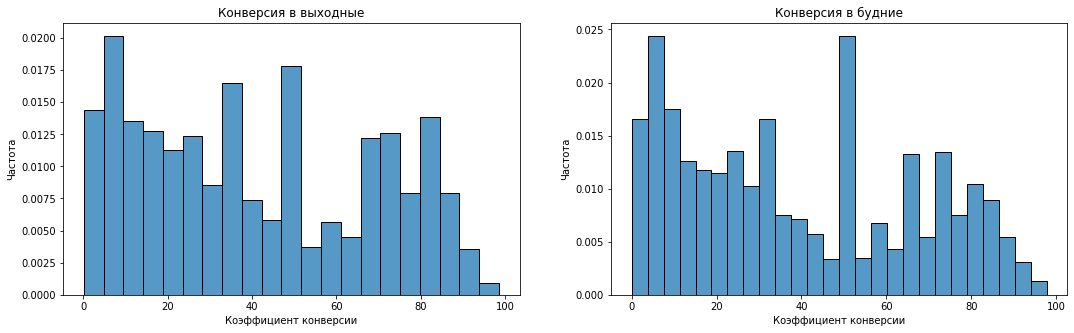

In [100]:
df["cr"] = df["transactions"]/df["visits"]*100
df["day_of_week"] = df.date.dt.day_name()
weekend = df.query("day_of_week in ('Saturday', 'Sunday') & transactions > 0 & cr < 100")
weekdays = df.query("day_of_week not in ('Saturday', 'Sunday') & transactions > 0 & cr < 100")
t, p_value = stats.ttest_ind(weekend["cr"], weekdays["cr"])
print(f"Значение t = {t}, p-value = {p_value}")
f, p_value = stats.f_oneway(weekend["cr"], weekdays["cr"])
print(f"Значение F = {f}, p-value = {p_value}")
u, p_value = stats.mannwhitneyu(weekend["cr"], weekdays["cr"])
print(f"Значение U = {u}, p-value = {p_value}")
#Построим графики распределения конверсии для наглядности
fig, axes = plt.subplots(1, 2, figsize = [18, 5])
a = 'Конверсия в выходные'
for ax in axes:
    ax.set_xlabel('Коэффициент конверсии')
    ax.set_ylabel('Частота')
    ax.set_title(a)
    a = 'Конверсия в будние'
sns.histplot(weekend["cr"], ax=axes[0], stat='density')
sns.histplot(weekdays["cr"], ax=axes[1], stat='density')

Несмотря на похожее распределение p-value во всех случаях значительно меньше 0.05, что позволяет отклонить нулевую гипотезу о равенстве средних конверсий. Итог: конверсия в выходные и в будни различна и это различие статистически значимо.

---
### d.	Вам необходимо спрогнозировать объем дохода, полученного с пользователей, приведенных на сайт контекстной рекламой (medium = cpc) на полгода вперед. Опишите, как бы вы подошли к этой задаче и какие дополнительные данные вам понадобятся?


<AxesSubplot:title={'center':'Изменение дохода в 2020 году с 1 января по 30 сентября'}, xlabel='date', ylabel='revenue'>

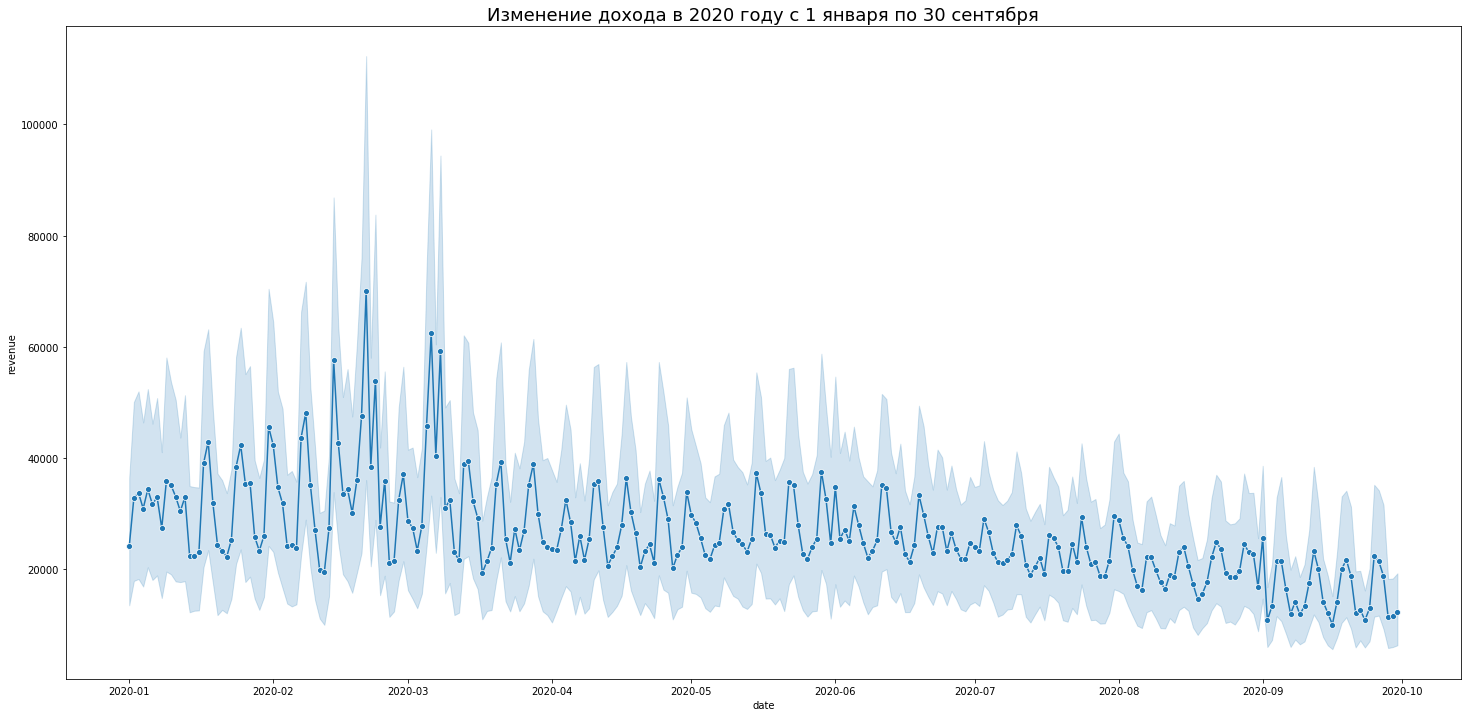

In [98]:
plt.figure(figsize=(25, 12))
plt.title(label="Изменение дохода в 2020 году с 1 января по 30 сентября", fontsize = 18)
sns.lineplot(data=df.query("medium == 'cpc'"), x='date', y='revenue', marker='o')